In [1]:
%%time
import datamapplot as dmp
import duckdb
from fast_hdbscan import HDBSCAN
from hashlib import md5
import joblib as jl
from matplotlib import colormaps
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.sparse as sp
import shlex
from sklearn.decomposition import TruncatedSVD
from tqdm.auto import tqdm
import umap
import vectorizers as vz
import vectorizers.transformers as vzt

import eng.bpe

2024-06-24 19:43:25.640774: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-24 19:43:25.644205: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-24 19:43:25.697395: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-24 19:43:25.697422: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-24 19:43:25.697452: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

CPU times: user 26.9 s, sys: 4.59 s, total: 31.5 s
Wall time: 28 s


In [2]:
tqdm.pandas()

Get the data from here: https://gdo168.llnl.gov/data/ACME-2023/stdview-20231105-20231120.tar

In [3]:
db = duckdb.connect(":memory:")

In [4]:
for table in ["process", "process_path", "process_image_load"]:
    db.execute(f"create or replace view {table} as select * from parquet_scan('/data/acme3/stdview-20231105-20231120/{table}.parquet')")

Drop the processes involved with the Amazon and Wintap agents.

In [5]:
db.execute(
    """
    create or replace view process_interesting as
    select process.*, process_path.ptree as ptree
    from process
    inner join process_path using (pid_hash)
    where process_path.ptree not like '%wintap%' and process_path.ptree not like '%amazon-ssm%'
    and process_started >= '2023-11-05'::timestamp
    and process_started = first_seen
    """
)

Here are the _interesting_ processes:

In [6]:
%%time
metadata_interesting = db.execute(
    """
    select pid_hash, parent_pid_hash, process_name, process_path, args, ptree
    from process_interesting
    order by pid_hash
    """
).df()
metadata_interesting

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

CPU times: user 5.68 s, sys: 1.15 s, total: 6.83 s
Wall time: 3.93 s


,pid_hash,parent_pid_hash,process_name,process_path,args,ptree
0,0000283F736E630ABFCC5AA836DA8DE6,6DB651F1EAD84F88801332945F69A5F2,rundll32.exe,c:\windows\system32\rundll32.exe,c:\windows\system32\windows.staterepositorycli...,=rundll32.exe->svchost.exe->services.exe->wini...
1,000057E3B323CF730E68A978E00E8E53,C991863B4324678B5FF92D1A04E11CF4,mergehelper.exe,c:\program files\wintap\mergertool\mergehelper...,c:\programdata\wintap\parquet\default_sensor\m...,=mergehelper.exe->smss.exe->smss.exe->ntoskrnl...
2,0000ED740D89D0FD67FEDD3A460D1233,E1BB141B4D041B0485BCA35B4A52725F,mscorsvw.exe,c:\windows\microsoft.net\framework64\v4.0.3031...,-startupevent 224 -interruptevent 0 -ngenproce...,=mscorsvw.exe->ngen.exe->ngentask.exe->taskhos...
3,00011F5A487D54C57AD3D7B5CF49B8D6,853E6A28F9CDE865C4D761475F2FE6DB,dsregcmd.exe,c:\windows\system32\dsregcmd.exe,$(arg0) $(arg1) $(arg2),=dsregcmd.exe->svchost.exe->services.exe->wini...
4,0001A7D9420F65F0E8B07E78E1D26B45,5319246012A53BB36BAC5DBDA231D7B0,microsoftedgeupdate.exe,c:\program files (x86)\microsoft\edgeupdate\mi...,/ua /installsource scheduler,=microsoftedgeupdate.exe->svchost.exe->service...
...,...,...,...,...,...,...
137842,FFFD4487BC268AEDAF4460E91D9EA109,4513F1678CB5D6E0E95F95DA0ECB2E2D,microsoftedgeupdate.exe,c:\program files (x86)\microsoft\edgeupdate\mi...,/ua /installsource scheduler,=microsoftedgeupdate.exe->svchost.exe->service...
137843,FFFE1903C27DA29570F2E06FF02ECD95,269548B3623B541DD38D6B73AFAC2244,msedge.exe,c:\program files (x86)\microsoft\edge\applicat...,--type=renderer --disable-nacl --disable-gpu-c...,=msedge.exe->na.exe->ntoskrnl.exe
137844,FFFE89C9D856A2CA183895879FD210E0,CC4EFBD4A491E06FB568D3BE2A7F3DA8,svchost.exe,c:\windows\system32\svchost.exe,-k netsvcs -p -s netsetupsvc,=svchost.exe->services.exe->wininit.exe->smss....
137845,FFFF1E20E3041AA26D33FB1C563C1AEF,381DD681D08B21CAA47EF823BB3AA8D1,python.exe,c:\users\user6\desktop\extend_bincfg\.venv\scr...,"""c:\users\user6\desktop\extend_bincfg\.venv\sc...",=python.exe->pip.exe->powershell.exe->code.exe...


# Command line embedding

In [7]:
cmdlines = (
    metadata_interesting
    .assign(space=" ")[["process_path", "space", "args"]]
    .dropna(subset=["process_path"]).fillna("")
    .sum(axis=1)
    .str.strip()
    .str.encode("ascii", errors="backslashreplace")
    .str.decode("ascii")
)
cmdlines

0         c:\windows\system32\rundll32.exe c:\windows\sy...
1         c:\program files\wintap\mergertool\mergehelper...
2         c:\windows\microsoft.net\framework64\v4.0.3031...
3         c:\windows\system32\dsregcmd.exe $(arg0) $(arg...
4         c:\program files (x86)\microsoft\edgeupdate\mi...
                                ...                        
137842    c:\program files (x86)\microsoft\edgeupdate\mi...
137843    c:\program files (x86)\microsoft\edge\applicat...
137844    c:\windows\system32\svchost.exe -k netsvcs -p ...
137845    c:\users\user6\desktop\extend_bincfg\.venv\scr...
137846    c:\windows\system32\backgroundtaskhost.exe -se...
Length: 137847, dtype: object

In [8]:
%%time
tokens, code_list, cmdlines_compressed = eng.bpe.train(cmdlines.unique().tolist(), vocab_size=600, max_char_code=127)
len(code_list), np.min([len(cc) for cc in cmdlines_compressed])

CPU times: user 48.4 s, sys: 8.12 s, total: 56.5 s
Wall time: 12.7 s


(600, 2)

In [9]:
%%time
cmdlines_vec = eng.bpe.vectorize(cmdlines.tolist(), code_list, max_char_code=127)
cmdlines_vec

CPU times: user 32.4 s, sys: 822 ms, total: 33.2 s
Wall time: 7.07 s


<137847x728 sparse matrix of type '<class 'numpy.int64'>'
	with 2647458 stored elements in COOrdinate format>

In [10]:
%%time
cmdlines_iwt = vzt.InformationWeightTransformer().fit_transform(cmdlines_vec)
cmdlines_iwt

CPU times: user 997 ms, sys: 55.3 ms, total: 1.05 s
Wall time: 878 ms


<137847x728 sparse matrix of type '<class 'numpy.float64'>'
	with 2647458 stored elements in Compressed Sparse Row format>

In [11]:
%%time
_lil = cmdlines_iwt.tolil()
_, i_unique, i_deunique, cmdline_counts = np.unique(
    [
        [*md5(np.asarray(ind)).digest(), *md5(np.asarray(dat)).digest()]
        for ind, dat in tqdm(zip(_lil.rows, _lil.data), total=cmdlines_iwt.shape[0])
    ],
    axis=0,
    return_index=True,
    return_inverse=True,
    return_counts=True
)
len(i_unique)

  0%|          | 0/137847 [00:00<?, ?it/s]

CPU times: user 2.34 s, sys: 177 ms, total: 2.52 s
Wall time: 2.51 s


30631

In [12]:
%%time
U_bow = umap.UMAP(
    n_neighbors=50,
    metric="hellinger",
    n_epochs=500,
    verbose=True
).fit(cmdlines_iwt[i_unique, :])#, y=metadata_interesting["process_name"].iloc[i_unique].map(process_name2label))
cmdlines_bow = U_bow.embedding_[i_deunique, :]
cmdlines_bow.shape

UMAP(angular_rp_forest=True, metric='hellinger', n_epochs=500, n_neighbors=50, verbose=True)
Mon Jun 24 19:43:55 2024 Construct fuzzy simplicial set
Mon Jun 24 19:43:55 2024 Finding Nearest Neighbors
Mon Jun 24 19:43:55 2024 Building RP forest with 14 trees
Mon Jun 24 19:43:58 2024 metric NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Mon Jun 24 19:46:11 2024 Finished Nearest Neighbor Search
Mon Jun 24 19:46:14 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Jun 24 19:47:38 2024 Finished embedding
CPU times: user 33min 3s, sys: 36min 5s, total: 1h 9min 9s
Wall time: 3min 43s


(137847, 2)

In [13]:
datamap_bow = U_bow.embedding_
datamap_bow.shape

(30631, 2)

In [14]:
hover_text = (
    metadata_interesting
    .iloc[i_unique]
    .assign(
        count_summary=pd.Series(cmdline_counts, index=metadata_interesting.iloc[i_unique].index).apply(lambda c: f"({c}x) " if c > 1 else ""),
        space=" "
    )[["count_summary", "process_name", "space", "args"]]
    .fillna("")
    .sum(axis=1)
    .apply(lambda cl: cl[:100] + "[...]" if len(cl) > 100 else cl)
    .tolist()
)
pd.Series(hover_text)

0        mscorsvw.exe -startupevent 3a4 -interruptevent...
1        msedge.exe --single-argument c:\users\user4\ap...
2        msedge.exe --type=utility --utility-sub-type=d...
3        msedge.exe --type=utility --utility-sub-type=d...
4        msedge.exe --type=utility --utility-sub-type=d...
                               ...                        
30626    mscorsvw.exe -startupevent 6f4 -interruptevent...
30627    python.exe c:\users\user6\desktop\extend_bincf...
30628    mscorsvw.exe -startupevent 3b8 -interruptevent...
30629    msedge.exe --type=utility --utility-sub-type=d...
30630    (2x) ls.exe -f --color=auto --show-control-cha...
Length: 30631, dtype: object

In [15]:
%%time
plot_bow = dmp.create_interactive_plot(
    datamap_bow,
    metadata_interesting.iloc[i_unique]["process_name"],
    hover_text = hover_text,
    initial_zoom_fraction=0.75,
    font_family="Roboto",
    title="ACME 3 processes",
    sub_title="Processes as bags of cooccurrence vectors of command line tokens",
    darkmode=True,
)
plot_bow

CPU times: user 544 ms, sys: 32.3 ms, total: 576 ms
Wall time: 746 ms


<InteractiveFigure width=100% height=800>

In [16]:
cmdlines_bpe = jl.Parallel(n_jobs=os.cpu_count())(
    jl.delayed(eng.bpe.bpe_encode)(cmdline, code_list, max_char_code=127)
    for cmdline in tqdm(cmdlines.iloc[i_unique])
)
pd.Series(cmdlines_bpe)

  0%|          | 0/30631 [00:00<?, ?it/s]

0          [375, 51, 97, 672, 497, 621, 54, 256, 128, 288]
1        [387, 320, 115, 397, 297, 185, 103, 641, 150, ...
2        [644, 215, 289, 476, 388, 357, 479, 56, 489, 4...
3        [644, 479, 289, 56, 476, 388, 357, 479, 56, 48...
4        [644, 215, 491, 476, 388, 357, 479, 56, 489, 4...
                               ...                        
30626       [375, 54, 102, 672, 54, 50, 545, 53, 102, 558]
30627    [583, 54, 92, 100, 159, 107, 326, 112, 92, 145...
30628         [505, 51, 98, 567, 51, 98, 545, 51, 98, 613]
30629    [644, 54, 49, 289, 476, 402, 357, 56, 603, 444...
30630                                  [725, 258, 402, 51]
Length: 30631, dtype: object

In [17]:
%%time
vz_cooc = vz.TokenCooccurrenceVectorizer(n_threads=4, n_iter=3).fit(cmdlines_bpe)
tokens_cooc = vz_cooc.cooccurrences_
tokens_cooc

/work/home/jchealy/.conda/envs/acme/lib/python3.11/site-packages/numba/core/utils.py:661: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",
/work/home/jchealy/.conda/envs/acme/lib/python3.11/site-packages/numba/core/utils.py:661: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",
/work/home/jchealy/.conda/envs/acme/lib/python3.11/site-packages/numba/core/utils.py:661: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  warnings.warn("First-class function type feature is experimental",


CPU times: user 36.3 s, sys: 5.15 s, total: 41.5 s
Wall time: 22.2 s


<575x1150 sparse matrix of type '<class 'numpy.float32'>'
	with 127538 stored elements in Compressed Sparse Row format>

In [18]:
%%time
tokens_svd = TruncatedSVD(n_components=512).fit_transform(tokens_cooc.tocsr())
tokens_svd.shape

CPU times: user 47.4 s, sys: 7.37 s, total: 54.7 s
Wall time: 2.18 s


(575, 512)

In [24]:
coo_distrib = np.array([
    [row, vz_cooc.token_label_dictionary_[token], count]
    for row, cc in enumerate(tqdm(cmdlines_bpe))
    for token, count in zip(*np.unique(cc, return_counts=True))
])
distrib = sp.coo_matrix((coo_distrib[:, 2], (coo_distrib[:, 0], coo_distrib[:, 1])))
distrib

  0%|          | 0/30631 [00:00<?, ?it/s]

<30631x575 sparse matrix of type '<class 'numpy.int64'>'
	with 819264 stored elements in COOrdinate format>

In [25]:
%%time
cmdlines_hg = vz.WassersteinVectorizer(max_distribution_size=tokens_svd.shape[0]).fit_transform(distrib, vectors=tokens_svd)
cmdlines_hg.shape

CPU times: user 30min 11s, sys: 5min 52s, total: 36min 3s
Wall time: 1min 26s


(30631, 128)

In [26]:
%%time
datamap_hg = umap.UMAP(n_neighbors=100, init = datamap_bow, metric="cosine", n_epochs=500, verbose=True).fit_transform(cmdlines_hg)
datamap_hg.shape

UMAP(angular_rp_forest=True, init=array([[-7.4423966 , -0.13141966],
       [12.97785   , 8.147294  ],
       [16.408768  , -2.8578959 ],
       ...,
       [-3.0724282 , -8.593359  ],
       [11.9653425 , -5.540235  ],
       [ 5.370802  , 0.6231136 ]], dtype=float32), metric='cosine', n_epochs=500, n_neighbors=100, verbose=True)
Mon Jun 24 19:58:50 2024 Construct fuzzy simplicial set
Mon Jun 24 19:58:50 2024 Finding Nearest Neighbors
Mon Jun 24 19:58:50 2024 Building RP forest with 14 trees
Mon Jun 24 19:58:53 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Mon Jun 24 19:59:14 2024 Finished Nearest Neighbor Search
Mon Jun 24 19:59:15 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Mon Jun 24 19:59:56 2024 Finished embedding
CPU times: user 23min 59s, sys: 8.01 s, total: 24min 7s
Wall time: 1min 6s


(30631, 2)

In [27]:
plot_hg = dmp.create_interactive_plot(
    datamap_hg,
    metadata_interesting.iloc[i_unique]["process_name"],
    hover_text=hover_text,
    font_family="Roboto",
    title="ACME 3 processes",
    sub_title="Processes as bags of cooccurrence vectors of command line tokens",
    enable_search=True,
    darkmode=True,
)
plot_hg

<InteractiveFigure width=100% height=800>

### Procrustes Alignment for better visual comparisons

In [57]:
import datamapplot
from vectorizers.utils import procrustes_align

In [29]:
datamap_bow_align, datamap_hg_align = procrustes_align(datamap_bow, datamap_hg, scale_to='first')

Map all but the top k labels to Unknown so that we don't try and plot them on a non-interactive plot.

In [55]:
base_data_labels = metadata_interesting.iloc[i_unique]["process_name"]
topk = base_data_labels.value_counts()[:30].index
base_data_labels.loc[~base_data_labels.isin(topk)] = 'Unlabelled'

/tmp/ipykernel_2487914/3954268768.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_data_labels.loc[~base_data_labels.isin(topk)] = 'Unlabelled'


Build a consistent colour pallette

In [58]:
base_data_map = datamap_bow_align

unique_non_noise_labels = [
    label for label in np.unique(base_data_labels) if label != "Unlabelled"
]
cluster_centers = np.asarray([
    base_data_map[base_data_labels== label].mean(axis=0)
    for label in unique_non_noise_labels
])
palette = datamapplot.palette_handling.palette_from_datamap(
    base_data_map,
    cluster_centers,
    hue_shift=0.0,
    radius_weight_power=1.0,
    min_lightness=15,
)
label_color_map = dict(zip(unique_non_noise_labels, palette))

Build a static datamap with a fixed colour palette and get it's x and y limits for future plot consistency.

  0%|          | 0/500 [00:00<?, ?it/s]

Resetting positions to accord with alignment


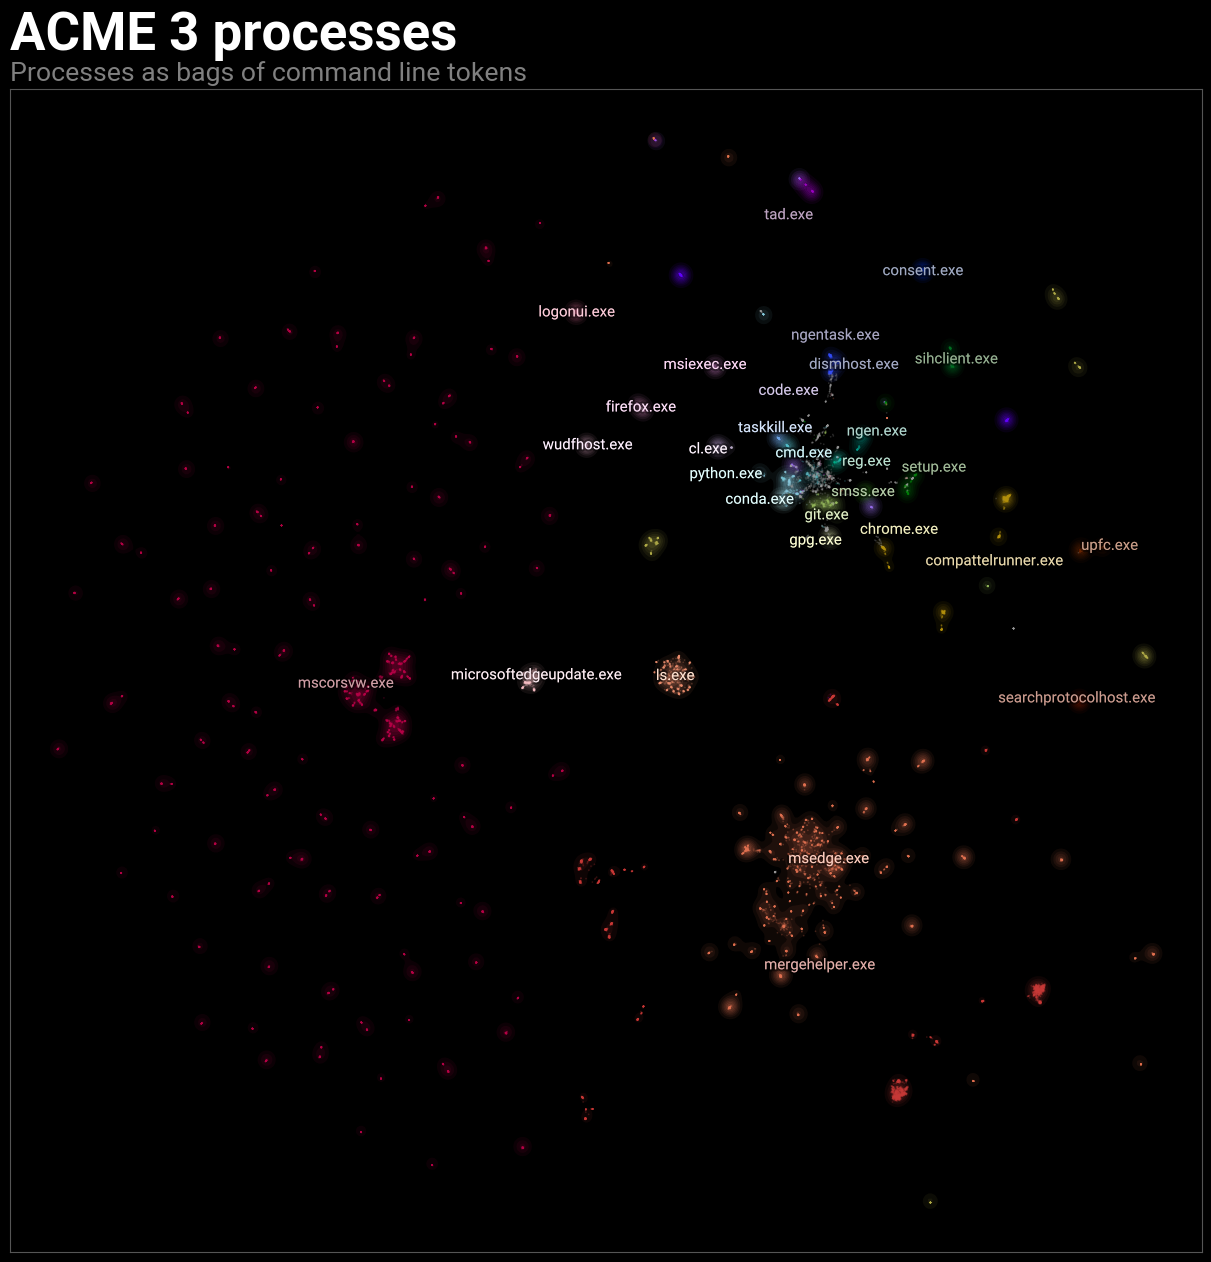

In [63]:
plot_bow_static, ax = dmp.create_plot(
    datamap_bow_align,
    base_data_labels,
    #hover_text=hover_text,
    font_family="Roboto",
    title="ACME 3 processes",
    sub_title="Processes as bags of command line tokens",
    #enable_search=True,
    darkmode=True,
    label_over_points=True,
    label_color_map=label_color_map,
)
xlim = ax.get_xlim()
ylim = ax.get_ylim()

plot_bow_static.savefig('acme3_bow_datamap.png', bbox_inches="tight")

Build a similar plot for a the wasserstein embedding with the same x and y limits.

  0%|          | 0/500 [00:00<?, ?it/s]

Resetting positions to accord with alignment


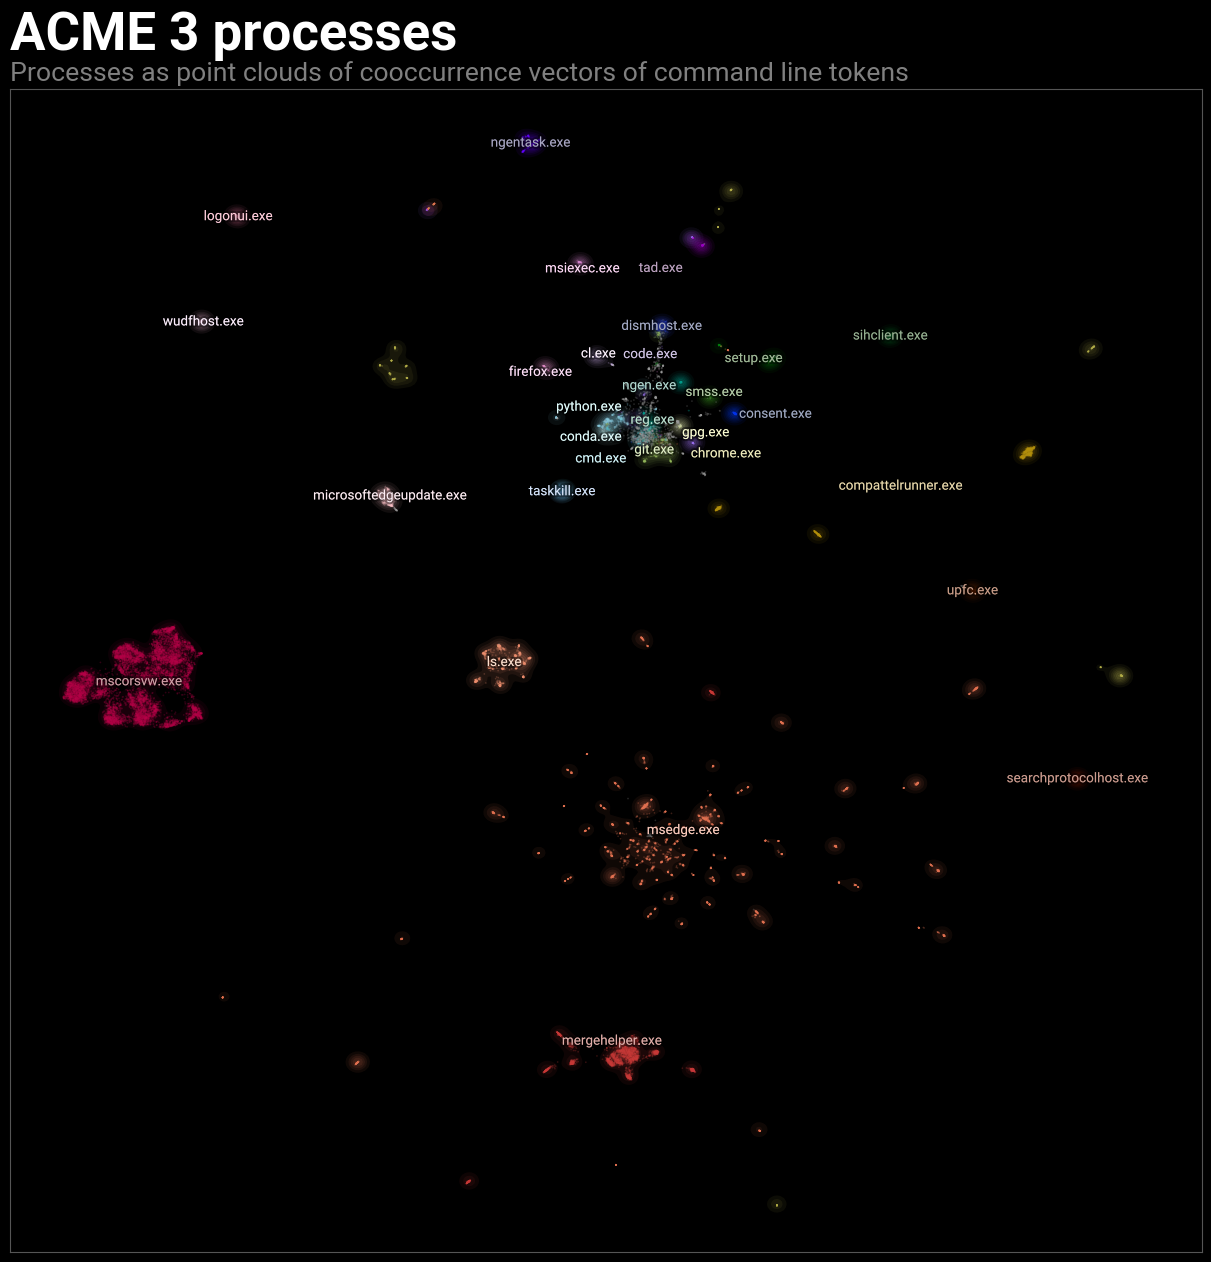

In [67]:
plot_hg_static, ax = dmp.create_plot(
    datamap_hg_align,
    base_data_labels,
    #hover_text=hover_text,
    font_family="Roboto",
    title="ACME 3 processes",
    sub_title="Processes as point clouds of cooccurrence vectors of command line tokens",
    #enable_search=True,
    darkmode=True,
    label_over_points=True,
    label_color_map=label_color_map,
)
ax.set_xlim = xlim
ax.set_ylim = ylim
plot_hg_static.savefig('acme3_wass_datamap.png', bbox_inches="tight")

## Now let's try fasttext

TODO: I need to use the BPE tokenizer here instead of the white space one.

In [33]:
try:
    import fasttext
except:
    !pip install fasttext-wheel
    import fasttext

In [34]:
cmdlines.drop_duplicates().to_csv('command_lines.txt',header=False, index=False)

In [35]:
model_name = "acme_commandline_embedding_tokenized_mincount50.ft"

try:
    print("Trying to load model")
    model = fasttext.load_model(model_name)
except:
    print("Training model")
    # zstdcat *.zstd > /tmp/hbs_cmdline_data.txt
    model = fasttext.train_unsupervised("command_lines.txt", thread=32, model="skipgram", minCount=50, epoch=10, dim=128)
    model.save_model(model_name)

Trying to load model


In [36]:
%%time

# Takes about 8 seconds to embed 50k command lines (~6_250 per second)
cmdlines_vec_ft_list = []
for i in cmdlines.tolist():#data['CommandLine'].values:
    cmdlines_vec_ft_list.append(model.get_sentence_vector(i.strip().replace("\n", " ")))
cmdlines_vec_ft = np.stack(cmdlines_vec_ft_list)

CPU times: user 8.25 s, sys: 464 ms, total: 8.71 s
Wall time: 8.34 s


In [39]:
datamap_ft = umap.UMAP(n_neighbors=50, init=datamap_bow, metric="cosine", verbose=True).fit_transform(cmdlines_vec_ft[i_unique])

UMAP(angular_rp_forest=True, init=array([[-7.4423966 , -0.13141966],
       [12.97785   , 8.147294  ],
       [16.408768  , -2.8578959 ],
       ...,
       [-3.0724282 , -8.593359  ],
       [11.9653425 , -5.540235  ],
       [ 5.370802  , 0.6231136 ]], dtype=float32), metric='cosine', n_neighbors=50, verbose=True)
Mon Jun 24 20:04:07 2024 Construct fuzzy simplicial set
Mon Jun 24 20:04:07 2024 Finding Nearest Neighbors
Mon Jun 24 20:04:07 2024 Building RP forest with 14 trees
Mon Jun 24 20:04:07 2024 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	Stopping threshold met -- exiting after 3 iterations
Mon Jun 24 20:04:12 2024 Finished Nearest Neighbor Search
Mon Jun 24 20:04:13 2024 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Mon Jun 24 20:04:28 2024 Finished embedding


Align the fasttext embedding via procrustes.  We are using the already aligned data because it has already been pre-centered and thus won't be altered by the current version of procrustes.

In [52]:
datamap_bow_align_2, datamap_ft_align = procrustes_align(datamap_bow_align, datamap_ft, scale_to='first')

  0%|          | 0/500 [00:00<?, ?it/s]

Resetting positions to accord with alignment


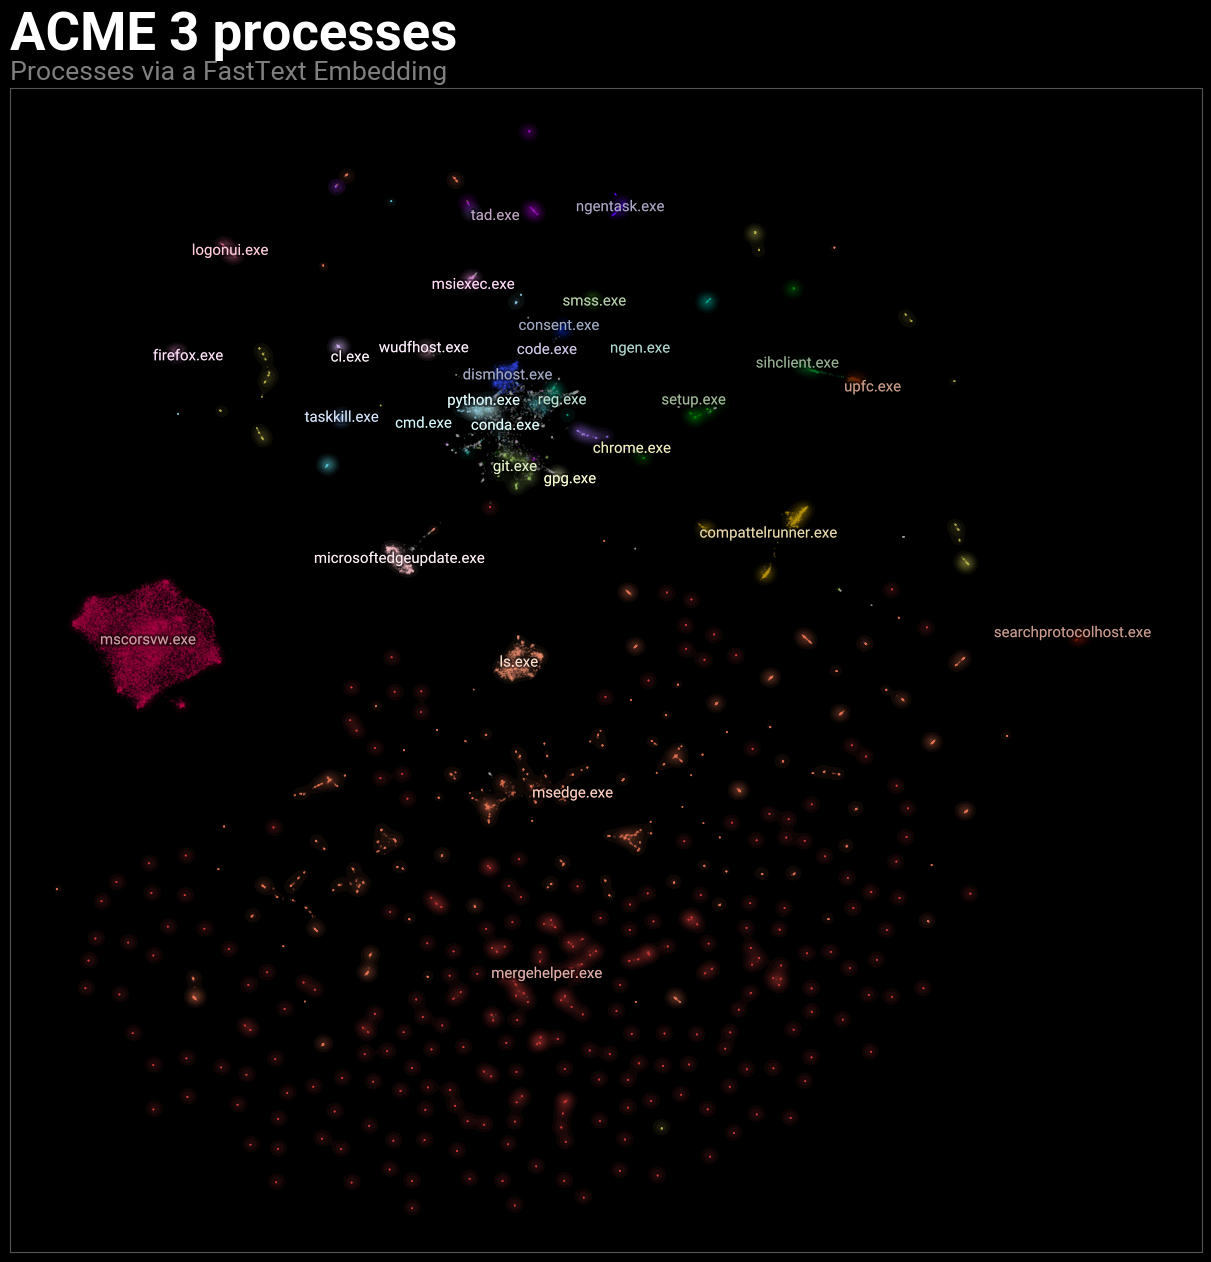

In [68]:
plot_ft_static, ax = dmp.create_plot(
    datamap_ft_align,
    base_data_labels,
    #hover_text=hover_text,
    font_family="Roboto",
    title="ACME 3 processes",
    sub_title="Processes via a FastText Embedding",
    #enable_search=True,
    darkmode=True,
    label_over_points=True,
    label_color_map=label_color_map,
)
ax.set_xlim = xlim
ax.set_ylim = ylim
plot_ft_static.savefig('acme3_fasttext_datamap.png', bbox_inches="tight")

---

In [ ]:
%load_ext magic_duckdb

In [ ]:
%dql -co db

In [ ]:
%%dql
select hostname, count(distinct pid_hash)
from process
group by hostname

In [ ]:
procs = db.execute(
    """
    select hostname, day, count(distinct pid_hash) as num
    from (
        select pid_hash, hostname, cast(datetrunc('day', process_started) as date) as day
        from process_interesting
        where process_started = first_seen
    )
    group by hostname, day
    order by hostname, day
    """
).df()
procs_nona = procs.dropna(subset=["day"])
procs_per_hostday = procs_nona.loc[procs_nona["day"] >= pd.Timestamp("2023-11-05")].set_index(["hostname", "day"]).unstack("day").fillna(0)
procs_per_hostday

---

In [ ]:
%%dql
describe process_image_load

In [ ]:
%%dql
create or replace view image_load as
select pid_hash, process_image_load.hostname, process_image_load.first_seen as timestamp, process_interesting.process_name, process_image_load.filename
from process_image_load
inner join process_interesting using (pid_hash)

In [ ]:
%%dql -o process_x_image
select pid_hash, process_name, array_agg(filename) as images, array_agg(timestamp) as timestamps
from image_load
group by pid_hash, process_name

In [ ]:
%%time
vz_ngram = vz.NgramVectorizer().fit(process_x_image["images"])
vz_ngram

In [ ]:
procdlls_vec = vz_ngram._train_matrix
procdlls_vec

In [ ]:
%%time
procdlls_iwt = vzt.InformationWeightTransformer().fit_transform(procdlls_vec)
procdlls_iwt

In [ ]:
%%time
_lil = procdlls_iwt.tolil()
_, i_unique, i_deunique, procdlls_counts = np.unique(
    [
        [*md5(np.asarray(ind)).digest(), *md5(np.asarray(dat)).digest()]
        for ind, dat in tqdm(zip(_lil.rows, _lil.data), total=procdlls_iwt.shape[0])
    ],
    axis=0,
    return_index=True,
    return_inverse=True,
    return_counts=True
)
len(i_unique)

In [ ]:
%%time
procdlls_bow_map = umap.UMAP(
    n_neighbors=15,
    metric="hellinger",
    verbose=True
).fit_transform(procdlls_iwt[i_unique, :])
procdlls_bow_map

In [ ]:
i_good, = np.nonzero(~np.isnan(procdlls_bow_map[:, 0]))
i_good

In [ ]:
cmap = colormaps.get("plasma")
procdlls_labels = pd.DataFrame({"label": np.sort(process_x_image["process_name"].iloc[i_unique].iloc[i_good].unique())})
procdlls_labels["n"] = np.arange(len(procdlls_labels)) / len(procdlls_labels)
procdlls_labels["color"] = procdlls_labels["n"].map(cmap) #.map(lambda n: "".join("{:02x}".format(c) for c in cmap(n, bytes=True)[:3]))
procdlls_labels
display(procdlls_labels)
label2color = procdlls_labels.set_index("label")["color"].to_dict()

In [ ]:
hover_text = [
    (f"({count}x) " if count > 1 else "") + f"{name}: " + " ".join(
        [p.split("\\")[-1] for p in imgs][:5]
    ) + (f" +{len(imgs) - 5}" if len(imgs) > 5 else "")
    for count, (name, imgs) in zip(procdlls_counts[i_good], process_x_image.iloc[i_unique].iloc[i_good][["process_name", "images"]].itertuples(index=False))
]
pd.Series(hover_text)

In [ ]:
plot_bow2 = dmp.create_interactive_plot(
    procdlls_bow_map[i_good, :],
    process_x_image["process_name"].iloc[i_unique].iloc[i_good],
    hover_text=hover_text,
    label_color_map=label2color,
    font_family="Roboto",
    title="ACME 3 processes",
    sub_title="Processes as bags of DLLs",
    enable_search=True,
    darkmode=True,
)
plot_bow2

In [ ]:
%%time
dll_cooc = vz.TokenCooccurrenceVectorizer().fit(process_x_image["images"])
dll_cooc.cooccurrences_

In [ ]:
%%time
dll_svd = TruncatedSVD(n_components=512).fit_transform(dll_cooc.cooccurrences_)
dll_svd.shape

In [ ]:
%%time
coo_distrib = np.array([
    (row, dll_cooc.token_label_dictionary_[token], count)
    for row, images in enumerate(process_x_image["images"])
    for token, count in zip(*np.unique(images, return_counts=True))
])
distrib = sp.coo_matrix((coo_distrib[:, 2], (coo_distrib[:, 0], coo_distrib[:, 1])))
distrib

In [ ]:
%%time
procdlls_hg = vz.WassersteinVectorizer().fit_transform(distrib, vectors=dll_svd)
procdlls_hg.shape

In [ ]:
%%time
procdlls_hg_map = umap.UMAP(metric="cosine", verbose=True).fit_transform(procdlls_hg)

In [ ]:
hover_text = [
    f"{name}: " + " ".join(
        [p.split("\\")[-1] for p in imgs][:5]
    ) + (f" +{len(imgs) - 5}" if len(imgs) > 5 else "")
    for name, imgs in process_x_image[["process_name", "images"]].itertuples(index=False)
]
pd.Series(hover_text)

In [ ]:
plot_hg2 = dmp.create_interactive_plot(
    procdlls_hg_map,
    process_x_image["process_name"],
    hover_text=hover_text,
    font_family="Roboto",
    title="ACME 3 processes",
    sub_title="Processes as bags of DLL cooccurrence vectors",
    enable_search=True,
    darkmode=True,
)
plot_hg2